##### 1. Import the dependencies
**For, collab, uncomment and install the packages specified below**

In [1]:
from mss import mss # used for screen capture 
import keyboard
import cv2 #used for image processing
import numpy as np 
import pytesseract #used for text recognition 
from matplotlib import pyplot as plt
import time
from gym import Env # used for creating custom environment
from gym.spaces import Box, Discrete # used for defining action and observation space

#### 2. Build the Environment

2.1 Create Environment

In [2]:
class ChromeDinoEnv(Env):
    def __init__(self):
        super(ChromeDinoEnv, self).__init__()
        
        # Define action space: 0 = do nothing, 1 = jump
        self.action_space = Discrete(3)
        
        # Define observation space (screen capture dimensions)
        self.observation_space = Box(low=0, high=255, shape=(300, 600, 3), dtype=np.uint8)
        
        # Screen capture setup
        self.sct = mss()
        self.game_location = {'top': 110, 'left': 50, 'width': 600, 'height': 500}
        self.done_location = {'top': 200, 'left': 600, 'width': 600, 'height': 70}
        
        # Initialize game state
        self.game_over = False
        

    def reset(self):
        # Reset the game (press space to restart)
        keyboard.press_and_release('space')
        time.sleep(1)  # Wait for the game to restart
        
        # Capture the initial observation
        observation = self._get_observation()
        self.game_over = False
        return observation

    def step(self, action):
        # Perform the action (0 = do nothing, 1 = jump, 2 = duck
        if action == 1:
            keyboard.press_and_release('up')
        elif action == 2:
            keyboard.press_and_release('down')
        # Wait for a short time to allow the game to update
        time.sleep(0.1)
        
        # Capture the new observation
        observation = self._get_observation()
        
        # Check if the game is over
        self.game_over, _ = self._check_game_over()
        
        # Define reward and done flag
        reward = 1 if not self.game_over else -10
        done = self.game_over
        
        return observation, reward, done

    def _get_observation(self):
        # Capture the screen
        raw = np.array(self.sct.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
        
        # return img

    def _check_game_over(self):
        # Use OCR to detect the "Game Over" text
        # gray = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        done_cap = np.array(self.sct.grab(self.done_location))
        text = pytesseract.image_to_string(done_cap).lower()
        
        # Check if "Game Over" is in the text
        done = False
        if "game" in text:
            done = True
        return done, done_cap

    def render(self, mode='human'):
        # Display the current observation (optional)
        observation = self._get_observation()
        
        # Reshape the observation to (83, 100) for display
        observation_2d = observation.squeeze()  # Remove the first dimension (1, 83, 100) -> (83, 100)
        
        # Normalize the observation to [0, 255] for display
        observation_2d = (observation_2d * 255).astype(np.uint8)
        
        cv2.imshow('Game', observation_2d)
        cv2.waitKey(1)

    def close(self):
        # Clean up
        cv2.destroyAllWindows()

In [5]:
time.sleep(4)
env = ChromeDinoEnv()

In [76]:
time.sleep(4)
obs = env._get_observation()

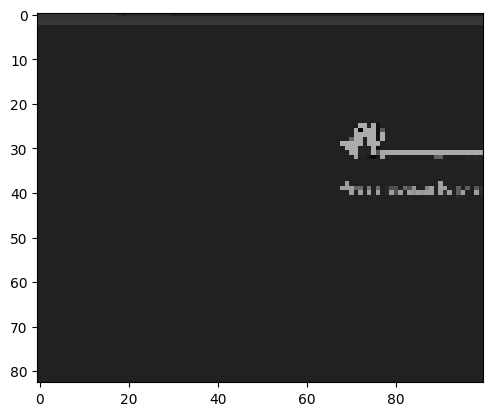

In [77]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [78]:
## Save the image
cv2.imwrite('dino-observation.png', obs[0])

True

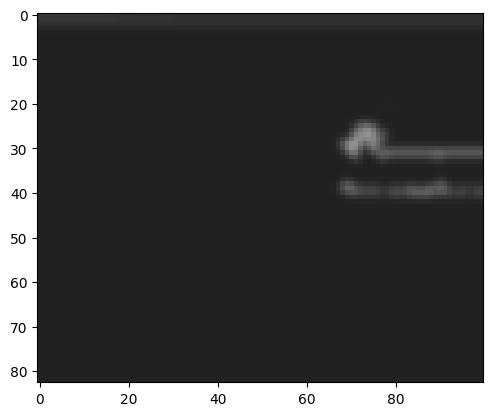

In [ ]:
## Apply a Gaussian blur
blurred = cv2.GaussianBlur(obs[0], (5, 5), 0)
## Apply histogram equalization to the blurred image

equalized = cv2.equalizeHist(blurred)
plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR))

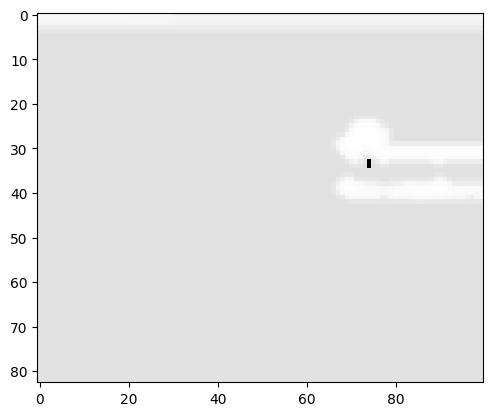

In [86]:
equalized = cv2.equalizeHist(blurred)
plt.imshow(cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR))

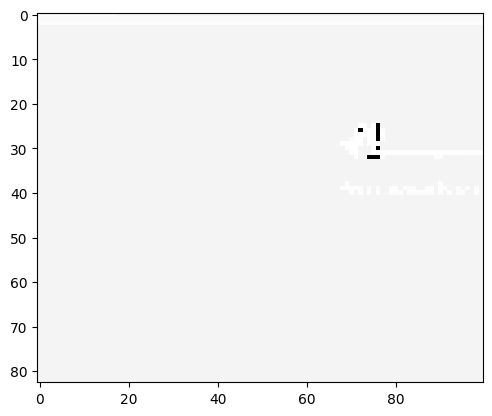

In [84]:
## Apply histogram equalization
equalized = cv2.equalizeHist(obs[0])
plt.imshow(cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR))

In [48]:
time.sleep(4)
done, done_cap = env._check_game_over()

In [49]:
done

True

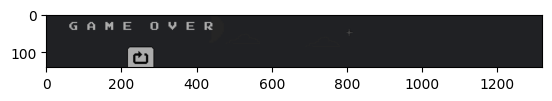

In [50]:
plt.imshow(cv2.cvtColor(done_cap, cv2.COLOR_BGR2RGB))

In [79]:
## Save the image
cv2.imwrite('dino-done.png', done_cap)

True

#### Add Logging for a simple Q-learning example

In [3]:
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler("./qlearning/dino_rl_training.log"),
        logging.StreamHandler()
    ]
)


# Initialize lists to store performance metrics
episode_rewards = []
episode_epsilons = []

#### Train and save the best model, log the output for each episode

In [7]:
from collections import defaultdict
import random
import pickle  # For saving the Q-table
# Define a regular function for the default factory
def default_q_value():
    return np.zeros(env.action_space.n)

# Initialize Q-table
Q = defaultdict(default_q_value)

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01



# Initialize variables to track the best performance
best_reward = -np.inf
best_model = None

# Training loop
time.sleep(5)
num_episodes = 1000
for episode in range(num_episodes):
    observation = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(Q[tuple(observation.flatten())])  # Exploit
        
        # Take the action
        next_observation, reward, done = env.step(action)
        
        # Update Q-value
        Q[tuple(observation.flatten())][action] += alpha * (
            reward + gamma * np.max(Q[tuple(next_observation.flatten())]) - Q[tuple(observation.flatten())][action])
        
        observation = next_observation
        total_reward += reward
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    # Log episode details
    logging.info(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")
    
    # Store metrics for plotting
    episode_rewards.append(total_reward)
    episode_epsilons.append(epsilon)
    
    # Check if this is the best model so far
    if total_reward > best_reward:
        best_reward = total_reward
        best_model = Q.copy()  # Save a copy of the Q-table
        logging.info(f"New best model found with reward: {best_reward}")
        
        # Save the best model to a file
        with open("./qlearning/best_model_qlearning.pkl", "wb") as f:
            pickle.dump(best_model, f)

env.close()

2025-03-27 01:46:50,302 [INFO] Episode: 1, Total Reward: 5, Epsilon: 0.995
2025-03-27 01:46:50,303 [INFO] New best model found with reward: 5
2025-03-27 01:46:51,740 [INFO] Episode: 2, Total Reward: -10, Epsilon: 0.990025
2025-03-27 01:46:57,678 [INFO] Episode: 3, Total Reward: 9, Epsilon: 0.985074875
2025-03-27 01:46:57,679 [INFO] New best model found with reward: 9
2025-03-27 01:47:05,445 [INFO] Episode: 4, Total Reward: 15, Epsilon: 0.9801495006250001
2025-03-27 01:47:05,445 [INFO] New best model found with reward: 15
2025-03-27 01:47:07,167 [INFO] Episode: 5, Total Reward: -10, Epsilon: 0.9752487531218751
2025-03-27 01:47:12,155 [INFO] Episode: 6, Total Reward: 5, Epsilon: 0.9703725093562657
2025-03-27 01:47:13,499 [INFO] Episode: 7, Total Reward: -10, Epsilon: 0.9655206468094844
2025-03-27 01:47:18,317 [INFO] Episode: 8, Total Reward: 4, Epsilon: 0.960693043575437
2025-03-27 01:47:19,680 [INFO] Episode: 9, Total Reward: -10, Epsilon: 0.9558895783575597
2025-03-27 01:47:27,200 [INF

### Simple plot on perfomance after each n episodes

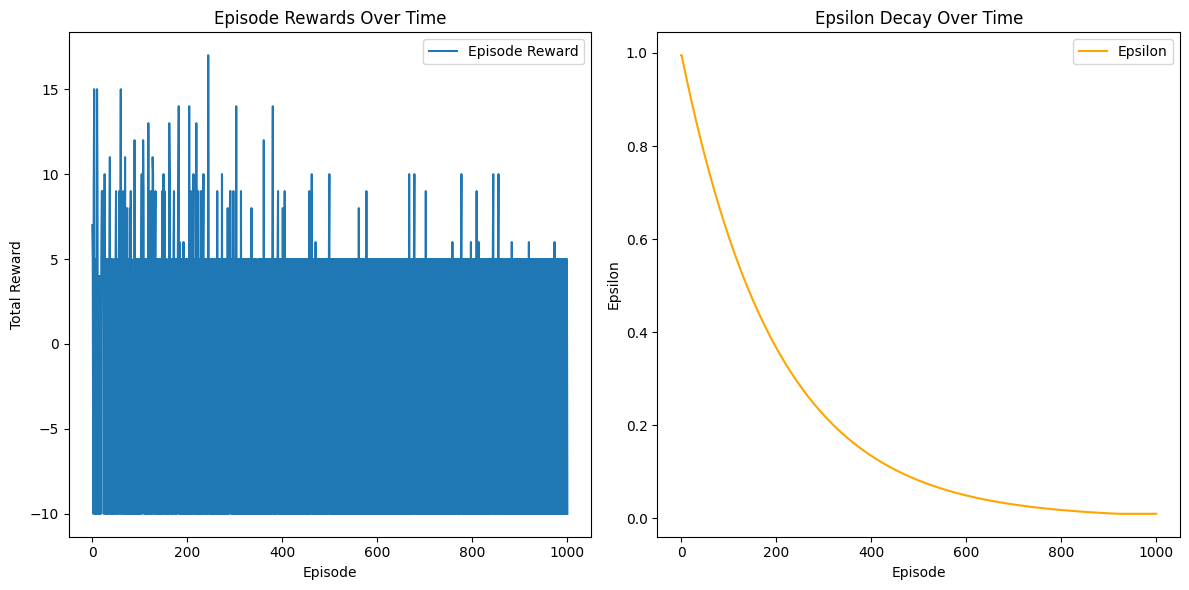

In [8]:
import matplotlib.pyplot as plt
# Plotting the performance
plt.figure(figsize=(12, 6))

# Plot episode rewards
plt.subplot(1, 2, 1)
plt.plot(episode_rewards, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode Rewards Over Time")
plt.legend()

# Plot epsilon values
plt.subplot(1, 2, 2)
plt.plot(episode_epsilons, label="Epsilon", color="orange")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay Over Time")
plt.legend()

plt.tight_layout()
plt.show()

#### 3. Loading the Best Model

In [12]:
time.sleep(5)
# Load the best model
with open("./qlearning/best_model_qlearning.pkl", "rb") as f:
    best_model = pickle.load(f)

for i in range(50):
    # Use the best model for testing
    observation = env.reset()
    done = False
    total_reward = 0

    while not done:
        # Use the best model to select actions
        action = np.argmax(best_model[tuple(observation.flatten())])
        print(f"Action: {action}")
        # Take the action
        observation, reward, done = env.step(action)
        total_reward += reward

    print(f"Total Reward using the best model: {total_reward}")
    env.close()

Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Total Reward using the best model: 7
Action: 0
Total Reward using the best model: -10
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Total Reward using the best model: 5
Action: 0
Total Reward using the best model: -10
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 0
Action: 

KeyboardInterrupt: 